## Parameter optimization for KMeans Clustering of daily consumption patterns

In [14]:
import polars as pl
import glob
import numpy as np
import os
import logging
from pathlib import Path
import re

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd

logging.getLogger('matplotlib.font_manager').disabled = True
from validation import validation

In [15]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_hourlyAveraged_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data = data_3d

Shape of the 3D array: (1464, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [16]:
# Your data: numpy array of shape (n_samples, n_features)
X = train_data.squeeze()  # Adjust if 3D is (n_samples, n_timestamps, 1)

# Define grid of hyperparameters
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8],
    'init': ['k-means++', 'random'],
    'n_init': [1, 10, 20],
    'max_iter': [300, 500]
}

import itertools
results = []

# Cartesian product of parameters
for n_clusters, init, n_init, max_iter in itertools.product(
    param_grid['n_clusters'],
    param_grid['init'],
    param_grid['n_init'],
    param_grid['max_iter']
):
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init,
        n_init=n_init,
        max_iter=max_iter,
        random_state=42
    )
    labels = kmeans.fit_predict(X)
    # Calculate scores only if more than 1 cluster
    if len(set(labels)) > 1:
        sil_score = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        results.append({
            'n_clusters': n_clusters,
            'init': init,
            'n_init': n_init,
            'max_iter': max_iter,
            'silhouette_score': sil_score,
            'db_score': db_score
        })

# Results as a DataFrame, sorted by silhouette score (descending)
results_df = pd.DataFrame(results).sort_values(by='silhouette_score', ascending=False)
print(results_df)

    n_clusters       init  n_init  max_iter  silhouette_score  db_score
0            2  k-means++       1       300          0.273257  1.478848
6            2     random       1       300          0.273257  1.478848
7            2     random       1       500          0.273257  1.478848
1            2  k-means++       1       500          0.273257  1.478848
2            2  k-means++      10       300          0.265305  1.493376
..         ...        ...     ...       ...               ...       ...
74           8  k-means++      10       300          0.152178  1.636045
60           7  k-means++       1       300          0.150264  1.617732
61           7  k-means++       1       500          0.150264  1.617732
72           8  k-means++       1       300          0.148199  1.687143
73           8  k-means++       1       500          0.148199  1.687143

[84 rows x 6 columns]


In [17]:
X = train_data.squeeze()  # adjust shape if needed

param_grid = {
    'n_clusters': [3, 4, 5, 6, 7, 8],
    'init': ['k-means++', 'random'],
    'n_init': [1, 5, 10, 15, 20],
    'max_iter': [100,  200, 300, 500]
}

results = []

for n_clusters, init, n_init, max_iter in itertools.product(
    param_grid['n_clusters'],
    param_grid['init'],
    param_grid['n_init'],
    param_grid['max_iter']
):
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init,
        n_init=n_init,
        max_iter=max_iter,
        random_state=42
    )
    labels = kmeans.fit_predict(X)
    if len(set(labels)) > 1:
        sil_score = silhouette_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        results.append({
            'n_clusters': n_clusters,
            'init': init,
            'n_init': n_init,
            'max_iter': max_iter,
            'silhouette_score': sil_score,
            'db_score': db_score
        })

results_df = pd.DataFrame(results).sort_values(by='silhouette_score', ascending=False)
print(results_df)

# Output best combination (highest silhouette score)
best_result = results_df.iloc[0]
print("\nBest combination of hyperparameters:")
print(best_result)

     n_clusters       init  n_init  max_iter  silhouette_score  db_score
0             3  k-means++       1       100          0.227933  1.460515
2             3  k-means++       1       300          0.227933  1.460515
3             3  k-means++       1       500          0.227933  1.460515
1             3  k-means++       1       200          0.227933  1.460515
31            3     random      10       500          0.227806  1.461160
..          ...        ...     ...       ...               ...       ...
160           7  k-means++       1       100          0.150264  1.617732
201           8  k-means++       1       200          0.148199  1.687143
203           8  k-means++       1       500          0.148199  1.687143
202           8  k-means++       1       300          0.148199  1.687143
200           8  k-means++       1       100          0.148199  1.687143

[240 rows x 6 columns]

Best combination of hyperparameters:
n_clusters                  3
init                k-means++
n_

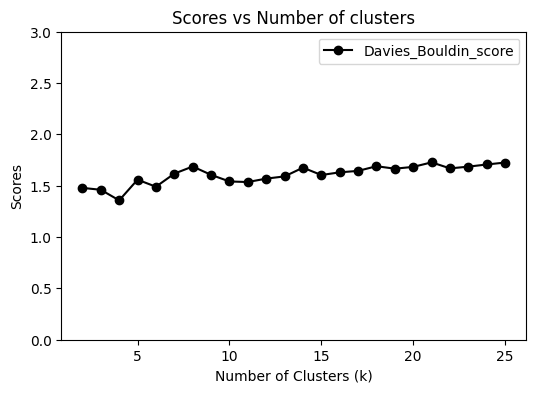

In [18]:
validation(train_data)